In [444]:
!pip install scikit-learn
!pip install pandas
!pip install xlrd openpyxl

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from models_tf import Sampler, NN_FF

from sklearn.model_selection import train_test_split
import pandas as pd

In [97]:


import tensorflow as tf
from Compute_Jacobian import jacobian
import numpy as np
import timeit

# Data Sampler
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    # Sample function
    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y
    

class NN_FF:
    #def __init__(self, layers, X_u, Y_u, a, u, sigma):
    def __init__(self, layers, X_u, Y_u, a, X_star, u_star, sigma):

        """
        :param layers: Layers of the network
        :param X_u, Y_u: Training data
        :param a:  Hyper-parameter of the target function
        :param u:  the target function
        :param sigma: Hyper-parameter of the Fourier features
        """

        self.mu_X, self.sigma_X = X_u.mean(0), X_u.std(0)
        #self.mu_x, self.sigma_x = self.mu_X[0], self.sigma_X[0]

        # Normalize the input of the network
        self.X_u = (X_u - self.mu_X) / self.sigma_X
        self.Y_u = Y_u

        # Initialize Fourier features
        # Initialize Fourier features across all input dimensions
        input_dim = X_u.shape[1]  # Handle multiple features
        self.W = tf.Variable(tf.random_normal([input_dim, layers[0] //2], dtype=tf.float32) * sigma, dtype=tf.float32, trainable=False)

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
            
        # Define the size of the Kernel
        self.D_u = X_u.shape[0]
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, input_dim))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_ntk_tf = tf.placeholder(tf.float32, shape=(self.D_u, input_dim))

        # Evaluate predictions
        #self.u_pred = self.net_u(self.x_u_tf)
        self.u_pred = self.forward_pass(self.x_u_tf)

        # Evaluate NTK predictions
        #self.u_ntk_pred = self.net_u(self.x_u_ntk_tf)
        self.u_ntk_pred = self.forward_pass(self.x_u_ntk_tf)
     
        # Boundary loss
        self.loss_u = tf.reduce_mean(tf.square(self.u_pred - self.u_tf))   
        
        # Total loss
        self.loss = self.loss_u

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)

        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

        # Model Saver
        self.saver = tf.train.Saver()

        # Compute the Jacobian for weights and biases in each hidden layer
#         self.J_u = self.compute_jacobian(self.u_ntk_pred)
        self.J_u = self.compute_jacobian(self.u_ntk_pred, self.x_u_ntk_tf)

#         # The empirical NTK = J J^T, compute NTK of PINNs
#         self.K = self.compute_ntk(self.J_u, self.x_u_ntk_tf, self.J_u, self.x_u_ntk_tf)

        # Loss Logger
        self.loss_u_log = []

        # NTK logger
        self.K_log = []

        # Weights logger
        self.weights_log = []
        self.biases_log = []

        # Training error and test error
        #N_train  = 100
        #N_test = 1000

        # Training data
        #self.X_train = np.linspace(0, 1, N_train)[:, None]
        #self.Y_train = u(self.X_train, a)
        self.X_train = self.X_u
        self.Y_train = self.Y_u
        
        # Test data
        #self.X_test = np.linspace(0, 1, N_test)[:, None]
        #self.Y_test = u(self.X_test, a)
        self.X_test = X_star
        self.Y_test = u_star

        # Error loggers
        self.train_error_log = []
        self.test_error_log = []

    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

#     # NTK initialization
#     def NTK_init(self, size):
#         in_dim = size[0]
#         out_dim = size[1]
#         std = 1. / np.sqrt(in_dim)
#         return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * std,
#                            dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random_normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluate the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        
        H = tf.concat([tf.sin(tf.matmul(H, self.W)),
                       tf.cos(tf.matmul(H, self.W))], axis=1)

        for l in range(0, num_layers - 2): # number_layers  - 1?
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Define the neural net
    #def net_u(self, x):
     #   u = self.forward_pass(x)
      #  return u

# #   Compute Jacobian for each weights and biases in each layer and retrun a list
#     def compute_jacobian(self, f):
#         J_list =[]
#         L = len(self.weights)
#         for i in range(L):
#             J_w = jacobian(f, self.weights[i])
#             J_list.append(J_w)

#         for i in range(L):
#             J_b = jacobian(f, self.biases[i])
#             J_list.append(J_b)
#         return J_list
    
#     def compute_jacobian(self, f, x, batch_size=1000):
#         """
#         Efficient Jacobian computation with minibatching.
#         f : tensor
#             Function output for which Jacobian needs to be computed.
#         x : tensor
#             Input tensor for which Jacobian needs to be computed.
#         batch_size : int
#             Number of rows to process in each minibatch.
#         """
#         J_list = []
#         num_batches = max(1, x.shape[0] // batch_size)  # Handle batches of data

#         for i in range(num_batches):
#             start = i * batch_size
#             end = min((i + 1) * batch_size, x.shape[0])
#             with tf.GradientTape(persistent=True) as tape:
#                 tape.watch(x[start:end])
#                 f_batch = f[start:end]
# #                 f_eval = tf.stop_gradient(f_batch)
#                 J_batch = tape.jacobian(f_batch, x[start:end])
#             J_list.append(J_batch)

#         return tf.concat(J_list, axis=0)  # Concatenate batches of Jacobians
    
#     def compute_jacobian(self, f, x, batch_size=1000):
#         J_list = []
#         num_batches = max(1, x.shape[0] // batch_size)

#         for i in range(num_batches):
#             start = i * batch_size
#             end = min((i + 1) * batch_size, x.shape[0])

#             # Use the tape only if there is no active tape
#             if tf.GradientTape()._recording:  # Check if a tape is already recording
#                 f_batch = f[start:end]
#                 J_batch = tf.zeros((f_batch.shape[0], x.shape[1]))  # Placeholder
#             else:
#                 with tf.GradientTape(persistent=True) as tape:
#                     tape.watch(x[start:end])
#                     f_batch = f[start:end]
#                     J_batch = tape.jacobian(f_batch, x[start:end])

#             J_list.append(J_batch)

#         return tf.concat(J_list, axis=0)

    def compute_jacobian(self, f, x, batch_size=1000, epsilon=1e-5):
        """
        Efficient Jacobian computation with minibatching without using tf.GradientTape.

        f : tensor
            Function output for which Jacobian needs to be computed.
        x : tensor
            Input tensor for which Jacobian needs to be computed.
        batch_size : int
            Number of rows to process in each minibatch.
        epsilon : float
            Small perturbation used for finite difference approximation.
        """
        J_list = []
        num_batches = max(1, x.shape[0] // batch_size)  # Handle batches of data

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, x.shape[0])
            f_batch = f[start:end]

            # Initialize Jacobian for this batch
            J_batch = []

            for j in range(x.shape[1]):  # Iterate over each input dimension
                # Perturb the input slightly in the positive direction
                x_plus = tf.identity(x[start:end])  # Create a copy
                x_plus = tf.tensor_scatter_nd_update(x_plus, 
                                                      tf.reshape(tf.range(x_plus.shape[0]), (-1, 1)),
                                                      tf.reshape(x_plus[:, j] + epsilon, (-1, 1)) * tf.ones((1, x.shape[1])))  # Adjusted to match shape
                f_plus = self.forward_pass(x_plus)

                # Perturb the input slightly in the negative direction
                x_minus = tf.identity(x[start:end])  # Create another copy
                x_minus = tf.tensor_scatter_nd_update(x_minus, 
                                                       tf.reshape(tf.range(x_minus.shape[0]), (-1, 1)),
                                                       tf.reshape(x_minus[:, j] - epsilon, (-1, 1)) * tf.ones((1, x.shape[1])))  # Adjusted to match shape
                f_minus = self.forward_pass(x_minus)

                # Compute the finite difference for each output
                J_col = (f_plus - f_minus) / (2 * epsilon)
                J_batch.append(J_col)

            # Stack the results to form the Jacobian for the batch
            J_batch = tf.concat(J_batch, axis=1)
            J_list.append(J_batch)

        return tf.concat(J_list, axis=0)  # Concatenate batches of Jacobians



#     # Compute the empirical NTK = J J^T
#     def compute_ntk(self, J1_list, x1, J2_list, x2):
#         D1 = x1.shape[0]
#         D2 = x2.shape[0]
#         N = len(J1_list)

#         Ker = tf.zeros((D1, D2))
#         for k in range(N):
#             J1 = tf.reshape(J1_list[k], shape=(D1, -1))
#             J2 = tf.reshape(J2_list[k], shape=(D2, -1))

#             K = tf.matmul(J1, tf.transpose(J2))
#             Ker = Ker + K
#         return Ker

    # Fetch minibatch
#     def fetch_minibatch(self, sampler, N):
#         X, Y = sampler.sample(N)
#         X = (X - self.mu_X) / self.sigma_X
#         return X, Y
    
    # Fetch mini-batch
    def fetch_minibatch(self, N):
        indices = np.random.choice(self.X_train.shape[0], N, replace=False)
        X_mb = self.X_train[indices]
        Y_mb = self.Y_train[indices]
        return X_mb, Y_mb

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, minibatch_size=1000, log_NTK=True, log_weights=True):

        start_time = timeit.default_timer()

        for it in range(nIter):
            # Fetch  mini-batches
#             Fetch minibatch data using the existing fetch_minibatch function
            X_mb, Y_mb = self.fetch_minibatch(minibatch_size)
        
            tf_dict = {self.x_u_tf: X_mb, self.u_tf: Y_mb}
            
            # Define a dictionary for associating placeholders with data
#             tf_dict = {self.x_u_tf: self.X_u, self.u_tf: self.Y_u
#                        }

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value = self.sess.run(self.loss_u, tf_dict)

                # Store the loss values
                self.loss_u_log.append(loss_u_value)

                # Compute the training error
                u_pred_train = self.predict_u(self.X_train)
                training_error = np.linalg.norm(self.Y_train - u_pred_train, 2) / np.linalg.norm(self.Y_train, 2)

                # Compute the test error
                u_pred_test = self.predict_u(self.X_test)
                test_error = np.linalg.norm(self.Y_test - u_pred_test, 2) / np.linalg.norm(self.Y_test, 2)

                # Store the training and test errors
                self.train_error_log.append(training_error)
                self.test_error_log.append(test_error)

                # print the loss values
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e,Time: %.2f' %
                      (it, loss_value, loss_u_value, elapsed))

                start_time = timeit.default_timer()

#             # Store the NTK matrix for every 100 iterations
#             if log_NTK:
#                 # provide x, x' for NTK
#                 if it % 100 == 0:
#                     print("Compute NTK...")
#                     tf_dict = {self.x_u_ntk_tf: self.X_u}
#                     K_value = self.sess.run(self.K, tf_dict)
#                     self.K_log.append(K_value)

            # Store the weights and biases of the network for every 100 iterations
            if log_weights:
                if it % 100 ==0:
                    print("Weights stored...")
                    weights = self.sess.run(self.weights)
                    biases = self.sess.run(self.biases)
                    
                    self.weights_log.append(weights)
                    self.biases_log.append(biases)
                
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x_u_tf: X_star}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star




In [447]:
# Load your Excel data file
data_file = 'data.xlsx'  # Ensure this path is correct
# df1 = pd.read_excel(data_file, sheet_name='Sheet1', engine='openpyxl', skiprows=2)
# df2 = pd.read_excel(data_file, sheet_name='Sheet2', engine='openpyxl', skiprows=2)
# df = pd.concat([df1, df2], ignore_index=True)
df = pd.read_excel(data_file, sheet_name='Sheet1', engine='openpyxl', skiprows=2)
df = df.dropna()
# Extract the first two columns for X and Y
#X = df.iloc[:, 2].values[:, None]  # First column for X
#Y = df.iloc[:, 3].values[:, None]  # Second column for Y

# Assume 'df' is your pandas DataFrame
# Define the group size
# group_size = 5000

# # Step 1: Create a group label for each block of 5000 rows
# df['group'] = np.floor(np.arange(len(df)) / group_size)

# # Step 2: Split the groups into training and testing sets
# unique_groups = df['group'].unique()

In [449]:
# Save DataFrame to Pickle file
df.to_pickle('data.pkl')

In [3]:
df = pd.read_pickle('data.pkl')

In [4]:
df.shape

(1046442, 11)

In [111]:
# # Perform train-test split on the groups, ensuring random splitting
# train_groups, test_groups = train_test_split(unique_groups, test_size=0.2, random_state=42)

# # Step 3: Select the rows belonging to the groups in the training and testing sets
# train_df = df[df['group'].isin(train_groups)].drop(columns=['group'])
# test_df = df[df['group'].isin(test_groups)].drop(columns=['group'])
# Step 1: Create a group label based on the first column (where zeros occur)
zero_mask = df.iloc[:, 0] == 0

# Use the mask to create group labels: increment the group number on each zero
df['group'] = zero_mask.cumsum()

# Step 2: Get unique groups
unique_groups = df['group'].unique()

# Step 3: Randomly select 50 groups (or fewer if there aren't 50)
selected_groups = np.random.choice(unique_groups, size=min(50, len(unique_groups)), replace=False)

# Step 4: Split the selected groups into training and testing sets
train_groups, test_groups = train_test_split(selected_groups, test_size=0.2, random_state=42)

# Step 3: Manually select specific groups for training and testing
# train_groups = [4, 13]  # Specify the group numbers for training
# test_groups = [6]       # Specify the group numbers for testing

# Step 5: Select the rows belonging to the groups in the training and testing sets
train_df = df[df['group'].isin(train_groups)].drop(columns=['group'])
test_df = df[df['group'].isin(test_groups)].drop(columns=['group'])

In [112]:
test_df_with_group = test_df.copy()  # Avoid dropping 'group' column
train_df_with_group = train_df.copy()  # Avoid dropping 'group' column
test_df_with_group['group'] = df[df['group'].isin(test_groups)]['group']  # Add the group column back
train_df_with_group['group'] = df[df['group'].isin(train_groups)]['group']  # Add the group column back

In [113]:
print(train_groups)
print(test_groups)
print(unique_groups.shape)

[126 111  87  44 160 123 146  16  64  34  52  91  15  77  12 158  89  78
  67  83  40   3  56  69 109  43 108 143  79  53  58 153 121  86 172 104
   2  68 103 100]
[192 155 202  73  99  39 173 136 159 147]
(206,)


In [114]:
#X = df.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]].values  # First column for X
#X = df.iloc[:, 0].values[:, None]

# X = df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values
# Y = df.iloc[:, 1].values[:, None]  # Second column for Y

X_train = train_df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values
# X_train = train_df.iloc[:, 0].values[:, None]
Y_train = train_df.iloc[:, 1].values[:, None]  # Second column for Y

X_test = test_df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values
# X_test = test_df.iloc[:, 0].values[:, None]
Y_test = test_df.iloc[:, 1].values[:, None]  # Second column for Y

# Split the data into 1000 training and 1000 testing points
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=100000, test_size=10000, shuffle=True, random_state=42)

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#     X_train = X
#     Y_train = Y
#     X_test = X
#     Y_test = Y

In [115]:
print(X_train.shape)
print(X_test.shape)

(204561, 7)
(50010, 7)


In [132]:


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt\

import seaborn as sns

#from models_tf import Sampler, NN_FF

from sklearn.model_selection import train_test_split
import pandas as pd


if __name__ == '__main__':
    
    N_u = 1000
    #X_u = np.linspace(dom_coords[0, 0],
     #                 dom_coords[1, 0], N_u)[:, None]
    
    X_u = X_train
    
    a = 2*1e13
    #Y_u = u(X_u, a)
    
    Y_u = Y_train
    
    # Test data
    nn = 1000
    #X_star = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
    #u_star = u(X_star, a)
    
    X_star = X_test
    u_star = Y_test
    
    # Define the model
    layers = [100, 100, 100, 1]
    sigma = 75   # Hyper-parameter of the Fourier features
    #model = NN_FF(layers, X_u, Y_u, a, u,  sigma)
    model = NN_FF(layers, X_u, Y_u, a,  X_star, u_star,  sigma)
    
    # Train the model for different epochs
    epoch_list = [10, 90, 900]  # 1000 iterations in total
    u_pred_list = []

    for epoch in epoch_list:
        # Train the model
        model.train(nIter=epoch, log_NTK=True, log_weights=True)
        u_pred = model.predict_u(X_star)
        u_pred_list.append(u_pred)
        # Predictions
       

    # Evaulate the relative l2 error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    print('Relative L2 error_u: {:.2e}'.format(error_u))

#     # Create loggers for the eigenvalues of the NTK
#     lambda_K_log = []

#     # Restore the NTK
#     K_list = model.K_log

#     for k in range(len(K_list)):
#         K = K_list[k]

#         # Compute eigenvalues
#         lambda_K, eigvec_K = np.linalg.eig(K)
        
#         # Sort in descresing order
#         lambda_K = np.sort(np.real(lambda_K))[::-1]
        
#         # Store eigenvalues
#         lambda_K_log.append(lambda_K)
        
#     # Change of the NTK
#     kernel_diff_list = []
#     K0 = K_list[0]
#     for K in K_list:
#         diff = np.linalg.norm(K - K0) / np.linalg.norm(K0) 
#         kernel_diff_list.append(diff)

    #######################
    #######################
    
    # Change of the weights
    def compute_weights_diff(weights_1, weights_2):
        weights = []
        N = len(weights_1)
        for k in range(N):
            weight = weights_1[k] - weights_2[k]
            weights.append(weight)
        return weights
    
    def compute_weights_norm(weights, biases):
        norm = 0
        for w in weights:
            norm = norm + np.sum(np.square(w))
        for b in biases:
            norm = norm + np.sum(np.square(b))
        norm = np.sqrt(norm)
        return norm
    
    # Restore the list weights and biases
    weights_log = model.weights_log
    biases_log = model.biases_log

    # The weights and biases at initialization
    weights_0 = weights_log[0]
    biases_0 = biases_log[0]
    
    weights_init_norm = compute_weights_norm(weights_0, biases_0)

    weights_change_list = []

    # Compute the change of weights and biases of the network
    N = len(weights_log)
    for k in range(N):
        weights_diff = compute_weights_diff(weights_log[k], weights_log[0])
        biases_diff = compute_weights_diff(biases_log[k], biases_log[0])
        
        weights_diff_norm = compute_weights_norm(weights_diff, biases_diff)
        weights_change = weights_diff_norm / weights_init_norm
        weights_change_list.append(weights_change)
    

    #################################
    ############## PLot##############
    #################################
    
#     train_indices = np.argsort(X_u, axis=0).flatten()
#     X_train_sorted = X_u[train_indices]
#     Y_train_sorted = Y_u[train_indices]

#     # Sort test data
#     test_indices = np.argsort(X_star, axis=0).flatten()
#     X_star_sorted = X_star[test_indices]
#     u_pred_sorted = u_pred[test_indices]
    
#     u_pred_epoc_10 = u_pred_list[0]
#     u_pred_epoc_10_sorted = u_pred_epoc_10[test_indices]
#     u_pred_epoc_100 = u_pred_list[1]
#     u_pred_epoc_100_sorted = u_pred_epoc_100[test_indices]
#     u_pred_epoc_200 = u_pred_list[2]
#     u_pred_epoc_200_sorted = u_pred_epoc_200[test_indices]
    
#     eigvec_K_0 = np.real(eigvec_K[:,0])
#     eigvec_K_0_sorted = eigvec_K_0[train_indices]
#     eigvec_K_1 = np.real(eigvec_K[:,1])
#     eigvec_K_1_sorted = eigvec_K_1[train_indices]
#     eigvec_K_2 = np.real(eigvec_K[:,2])
#     eigvec_K_2_sorted = eigvec_K_2[train_indices]
#     eigvec_K_3 = np.real(eigvec_K[:,3])
#     eigvec_K_3_sorted = eigvec_K_3[train_indices]
#     eigvec_K_4 = np.real(eigvec_K[:,4])
#     eigvec_K_4_sorted = eigvec_K_4[train_indices]
#     eigvec_K_5 = np.real(eigvec_K[:,5])
#     eigvec_K_5_sorted = eigvec_K_5[train_indices]
    
    # Model predictions
    #fig = plt.figure(1, figsize=(40, 5))
    #plt.subplot(1,2,1)
    #plt.plot(X_u, Y_u, '--', label='Exact')
    #plt.plot(X_star, u_pred, '--', label='u_pred')
    #plt.legend()
    
#     fig = plt.figure(1, figsize=(40, 5))
#     plt.subplot(1,2,1)
#     plt.plot(X_train_sorted[:, 0], Y_train_sorted, '--', label='Exact')
#     plt.plot(X_star_sorted[:, 0], u_pred_sorted, '--', label='u_pred')
#     plt.legend()
    
    #plt.subplot(1,2,2)
    #plt.plot(X_star, u_star - u_pred, label='Error')
    #plt.legend()
    #plt.tight_layout()
    #plt.show()
    
#     # Eigenvalues of NTK
#     fig = plt.figure(2, figsize=(6, 5))
#     plt.plot(lambda_K_log[0], label = 'n=0')
#     plt.plot(lambda_K_log[-1], '--', label = 'n=40,000')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('index')
#     plt.ylabel(r'$\lambda_{uu}$')
#     plt.title(r'Eigenvalues of ${K}_{uu}$')
#     plt.legend()
#     plt.show()

#     # Loss values
#     loss_u = model.loss_u_log
#     fig_3 = plt.figure(3, figsize=(6,5))
#     plt.plot(loss_u, label='$\mathcal{L}_{u_b}$')
#     plt.yscale('log')
#     plt.xlabel('iterations')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    


#     # Visualize the eigenvectors of the NTK
#     fig = plt.figure(figsize=(12, 6))
#     with sns.axes_style("darkgrid"):
#         plt.subplot(2,3,1)
#         plt.plot(X_u,  np.real(eigvec_K[:,0]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,2)
#         plt.plot(X_u,  np.real(eigvec_K[:,1]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,3)
#         plt.plot(X_u,  np.real(eigvec_K[:,2]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,4)
#         plt.plot(X_u,  np.real(eigvec_K[:,3]))
#         plt.tight_layout()
    
#         plt.subplot(2,3,5)
#         plt.plot(X_u,  np.real(eigvec_K[:,4]))
#         plt.tight_layout()
        
#         plt.subplot(2,3,6)
#         plt.plot(X_u,  np.real(eigvec_K[:,5]))
    
#         plt.tight_layout()
#         plt.show()
        
#     # Visualize the eigenvectors of the NTK
#     fig = plt.figure(figsize=(12, 6))
#     with sns.axes_style("darkgrid"):
#         plt.subplot(2,3,1)
#         plt.plot(X_train_sorted,  eigvec_K_0_sorted)
#         plt.tight_layout()
        
#         plt.subplot(2,3,2)
#         plt.plot(X_train_sorted,  eigvec_K_1_sorted)
#         plt.tight_layout()
        
#         plt.subplot(2,3,3)
#         plt.plot(X_train_sorted,  eigvec_K_2_sorted)
#         plt.tight_layout()
        
#         plt.subplot(2,3,4)
#         plt.plot(X_train_sorted,  eigvec_K_3_sorted)
#         plt.tight_layout()
    
#         plt.subplot(2,3,5)
#         plt.plot(X_train_sorted,  eigvec_K_4_sorted)
#         plt.tight_layout()
        
#         plt.subplot(2,3,6)
#         plt.plot(X_train_sorted,  eigvec_K_5_sorted)
    
#         plt.tight_layout()
#         plt.show()
    
#     # Visualize the eigenvalues of the NTK
#     fig = plt.figure(figsize=(6, 5))
#     with sns.axes_style("darkgrid"):
#         plt.plot(lambda_K_log[0], label=r'$\sigma={}$'.format(sigma))
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.xlabel('index')
#         plt.ylabel(r'$\lambda$') 
#         plt.title('Spectrum')
#         plt.tight_layout()
#         plt.legend()
#         plt.show()
        
        
#     # Model predictions at different epoch
#     fig = plt.figure(figsize=(12,4))
#     with sns.axes_style("darkgrid"):
#         plt.subplot(1,3,1)
#         plt.plot(X_u, Y_u, 'o')
#         plt.plot(X_star,  u_star, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star,  u_pred_list[0], color='C3', linestyle='--')
#         plt.title('Epoch = 10')
#         plt.tight_layout()
        
#         plt.subplot(1,3,2)
#         plt.plot(X_u, Y_u, 'o')
#         plt.plot(X_star,  u_star, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star,  u_pred_list[1], color='C3', linestyle='--')
#         plt.title('Epoch = 100')
#         plt.tight_layout()
        
#         plt.subplot(1,3,3)
#         plt.plot(X_u, Y_u, 'o')
#         plt.plot(X_star,  u_star, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star,  u_pred_list[2], color='C3', linestyle='--')
#         plt.title('Epoch = 200')
#         plt.tight_layout()
#         plt.show()
        
        
    # Model predictions at different epoch
#     fig = plt.figure(figsize=(12,4))
#     with sns.axes_style("darkgrid"):
#         plt.subplot(1,3,1)
#         plt.plot(X_train_sorted, Y_train_sorted, 'o')
#         plt.plot(X_star_sorted,  u_pred_sorted, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star_sorted,  u_pred_epoc_10_sorted, color='C3', linestyle='--')
#         plt.title('Epoch = 10')
#         plt.tight_layout()
        
#         plt.subplot(1,3,2)
#         plt.plot(X_train_sorted, Y_train_sorted, 'o')
#         plt.plot(X_star_sorted,  u_pred_sorted, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star_sorted,  u_pred_epoc_100_sorted, color='C3', linestyle='--')
#         plt.title('Epoch = 100')
#         plt.tight_layout()
        
#         plt.subplot(1,3,3)
#         plt.plot(X_train_sorted, Y_train_sorted, 'o')
#         plt.plot(X_star_sorted,  u_pred_sorted, color = 'C0', alpha=0.4, linewidth=6)
#         plt.plot(X_star_sorted,  u_pred_epoc_200_sorted, color='C3', linestyle='--')
#         plt.title('Epoch = 200')
#         plt.tight_layout()
#         plt.show()

Device mapping:

It: 0, Loss: 3.077e-01, Loss_bcs: 3.077e-01,Time: 310.36
Weights stored...
It: 0, Loss: 2.655e-01, Loss_bcs: 2.655e-01,Time: 0.69
Weights stored...
It: 0, Loss: 1.403e-01, Loss_bcs: 1.403e-01,Time: 0.72
Weights stored...
It: 100, Loss: 1.237e-01, Loss_bcs: 1.237e-01,Time: 68.56
Weights stored...
It: 200, Loss: 8.592e-02, Loss_bcs: 8.592e-02,Time: 68.49
Weights stored...
It: 300, Loss: 5.835e-02, Loss_bcs: 5.835e-02,Time: 68.57
Weights stored...
It: 400, Loss: 3.995e-02, Loss_bcs: 3.995e-02,Time: 68.64
Weights stored...
It: 500, Loss: 2.868e-02, Loss_bcs: 2.868e-02,Time: 68.65
Weights stored...
It: 600, Loss: 2.204e-02, Loss_bcs: 2.204e-02,Time: 68.64
Weights stored...
It: 700, Loss: 1.696e-02, Loss_bcs: 1.696e-02,Time: 68.60
Weights stored...
It: 800, Loss: 1.280e-02, Loss_bcs: 1.280e-02,Time: 69.29
Weights stored...
Relative L2 error_u: 1.09e+00


In [ ]:
fig = plt.figure(1, figsize=(40, 5))
plt.subplot(1,2,1)
plt.plot(X_train_sorted[:30000,0], Y_train_sorted[:30000], '--', label='Exact')
plt.plot(X_star_sorted[:30000,0], u_pred_sorted[:30000], '--', label='u_pred')
plt.legend()

In [ ]:
test_groups

In [365]:
# Step 2: Select a specific group from the test data for plotting
specific_group = 35  # Change this to the group number you want to plot

# Filter rows belonging to the specific group
group_df = test_df_with_group[test_df_with_group['group'] == specific_group]

In [366]:
print(u_pred.shape)
print(group_df.head())

(20004, 1)
                 0.0  -5.65604e-05    9000.0  40.0  77.0  0.1  4.07  17.14  \
175069  0.000000e+00     -0.000071  130000.0  60.0  77.0  0.1  4.07  17.14   
175070  1.000000e-14     -0.579370  130000.0  60.0  77.0  0.1  4.07  17.14   
175071  2.000000e-14     -0.707890  130000.0  60.0  77.0  0.1  4.07  17.14   
175072  3.000000e-14     -0.754630  130000.0  60.0  77.0  0.1  4.07  17.14   
175073  4.000000e-14     -0.780170  130000.0  60.0  77.0  0.1  4.07  17.14   

        0.74  5.7  0.00014  group  
175069  0.74  5.7  0.00014     35  
175070  0.74  5.7  0.00014     35  
175071  0.74  5.7  0.00014     35  
175072  0.74  5.7  0.00014     35  
175073  0.74  5.7  0.00014     35  


In [367]:
# Get the corresponding X_star and u_star for the selected group
X_group = group_df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values  # X_test for the specific group
u_group = group_df.iloc[:, 1].values[:, None]  # Y_test (u_star) for the specific group

# Get predicted values corresponding to these indices from u_pred
group_indices = group_df.index
u_pred_group = u_pred[np.isin(test_df_with_group.index, group_indices)]  # Use boolean indexing

In [368]:
# Step 3: Sort the values for plotting
sorted_indices = np.argsort(X_group[:, 0])  # Sort based on the first column (X-axis)
X_group_sorted = X_group[sorted_indices]
u_group_sorted = u_group[sorted_indices]
u_pred_group_sorted = u_pred_group[sorted_indices]

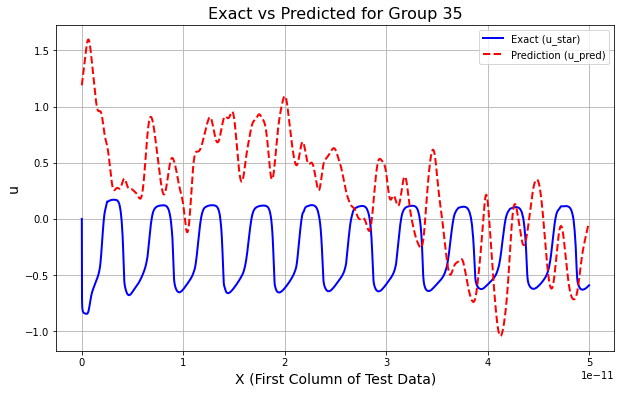

In [369]:
# Step 4: Plot the results
fig = plt.figure(figsize=(10, 6))

plt.plot(X_group_sorted[:, 0], u_group_sorted, 'b-', label='Exact (u_star)', linewidth=2)  # Exact values
plt.plot(X_group_sorted[:, 0], u_pred_group_sorted, 'r--', label='Prediction (u_pred)', linewidth=2)  # Predicted values

plt.xlabel('X (First Column of Test Data)', fontsize=14)
plt.ylabel('u', fontsize=14)
plt.title(f'Exact vs Predicted for Group {specific_group}', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

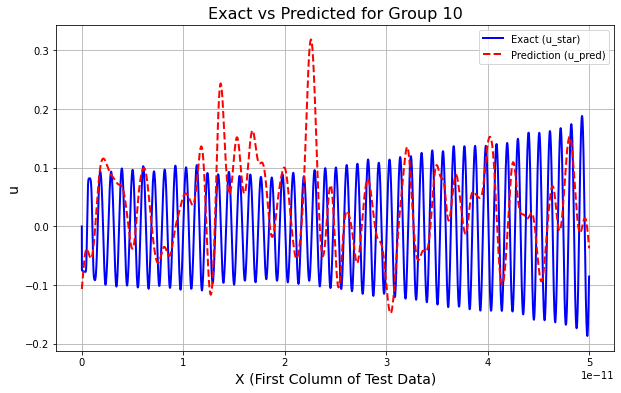

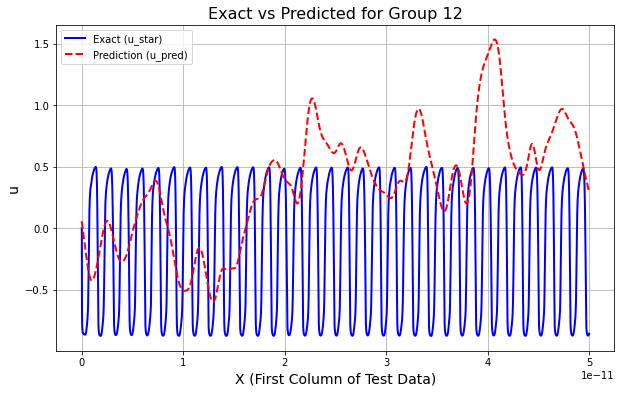

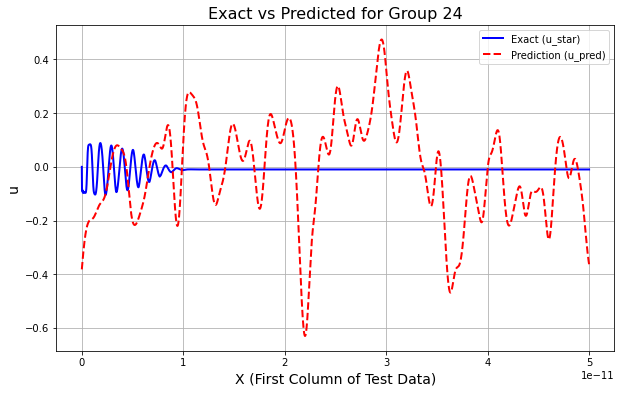

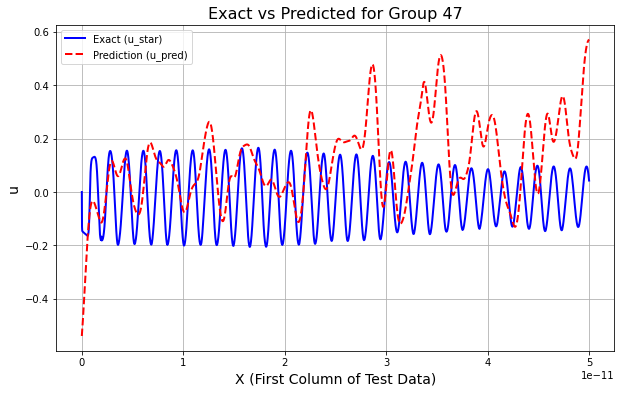

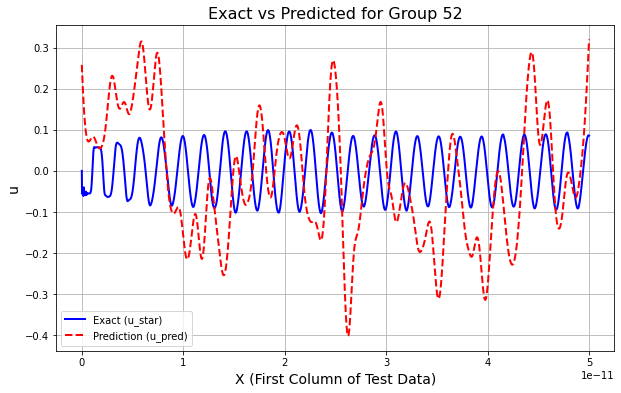

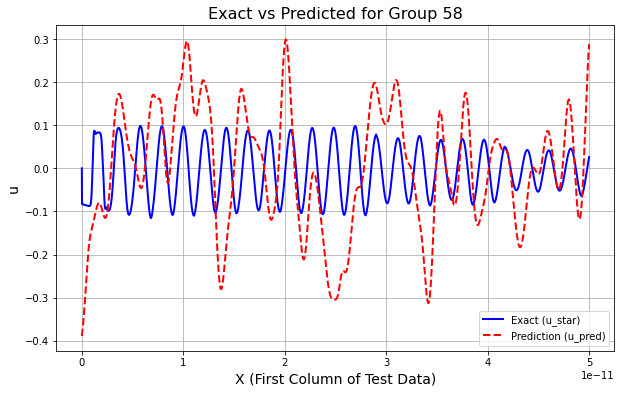

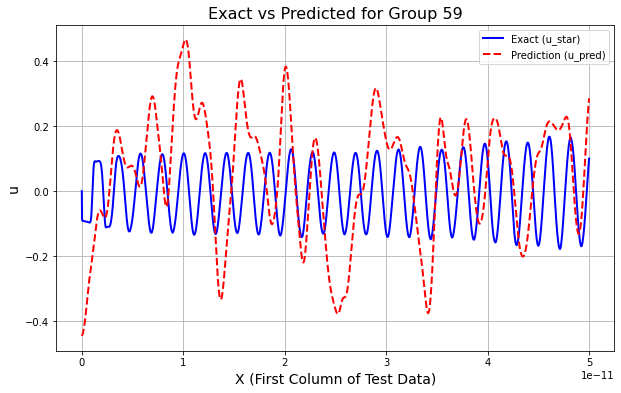

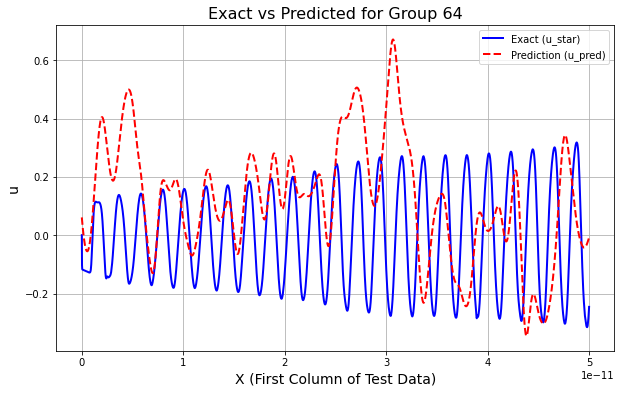

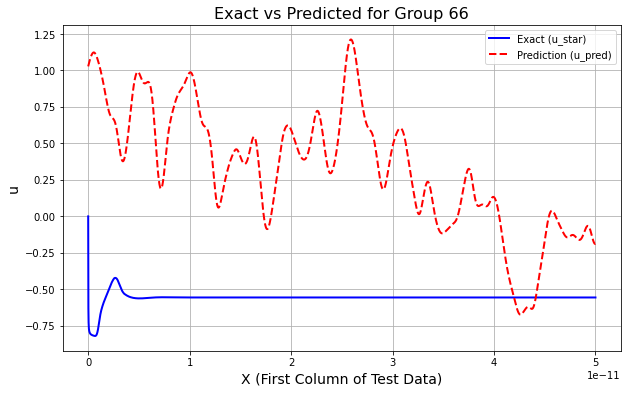

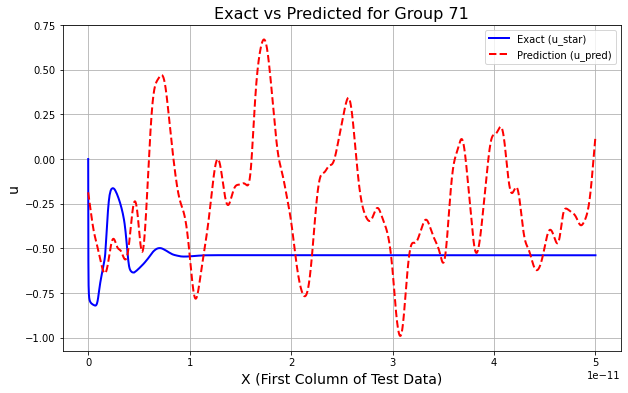

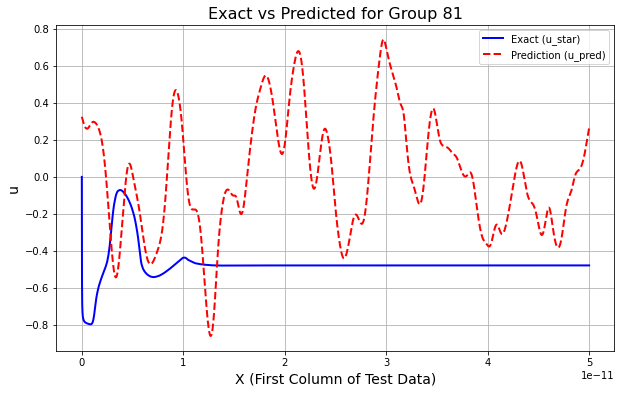

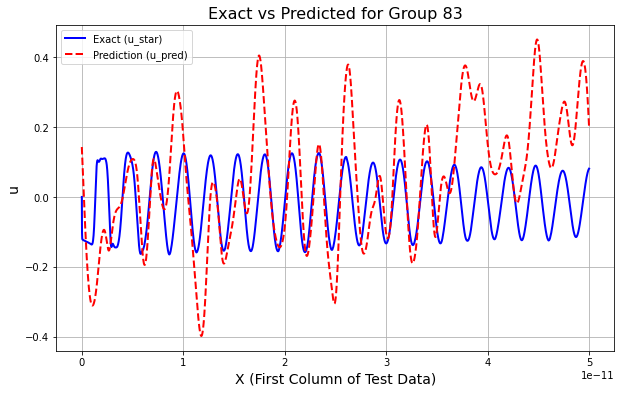

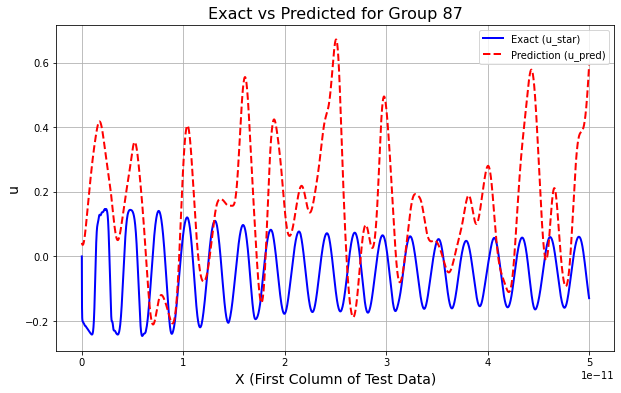

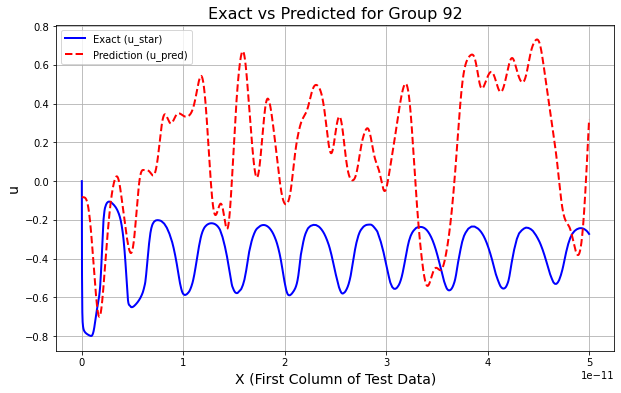

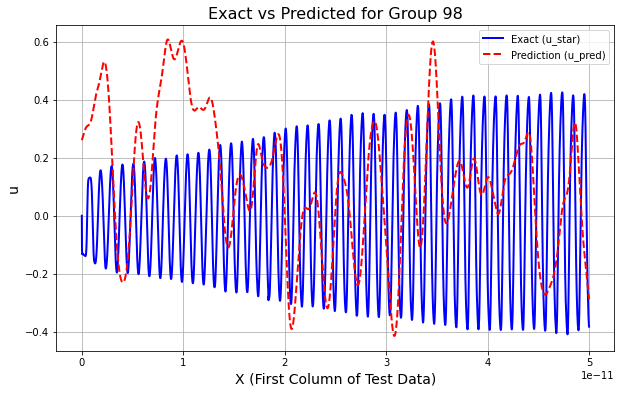

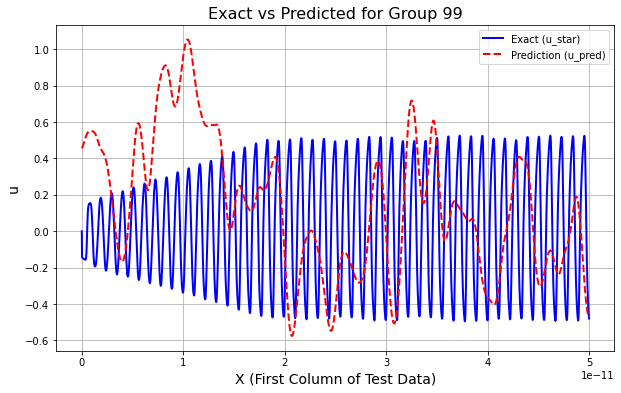

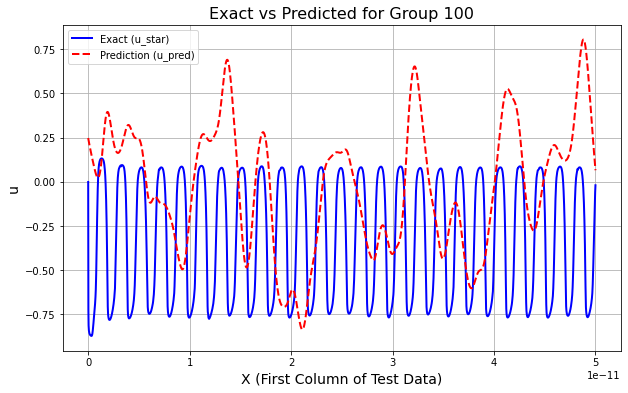

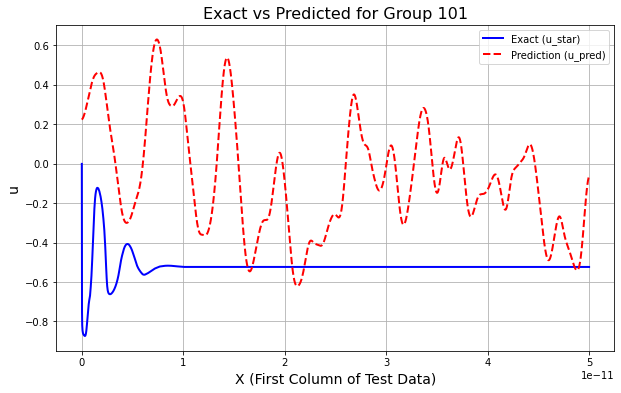

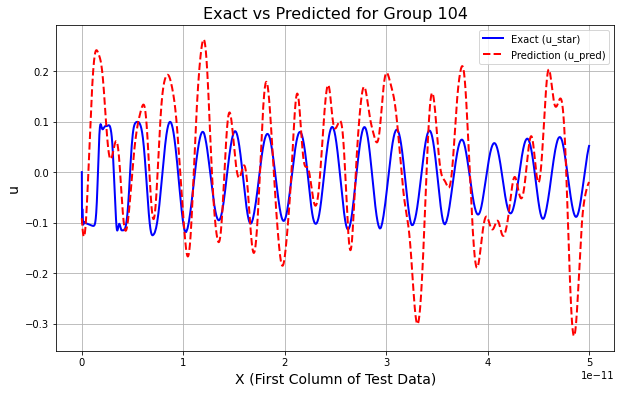

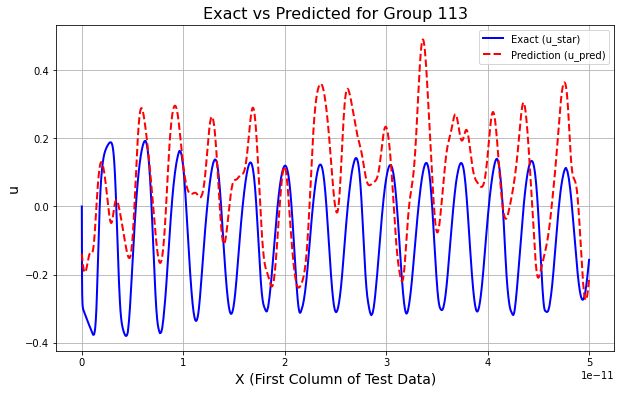

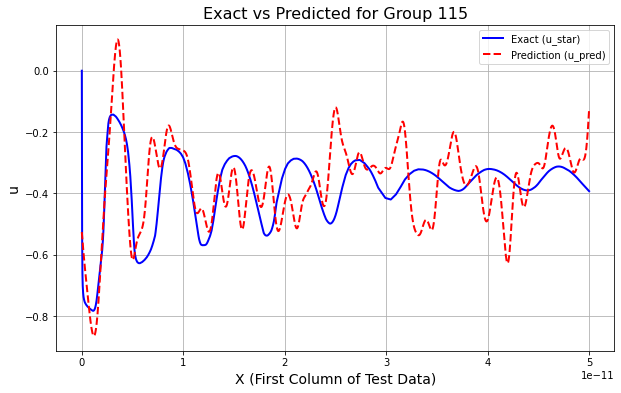

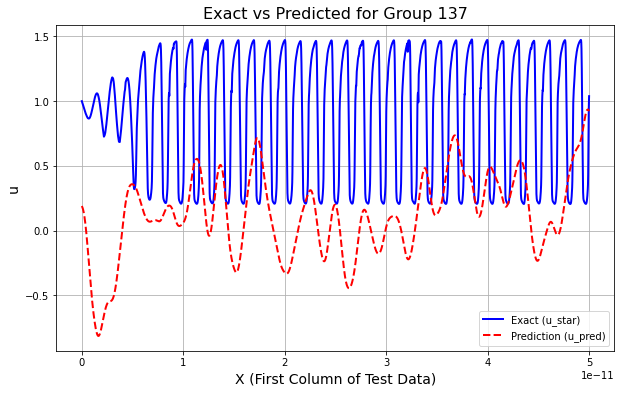

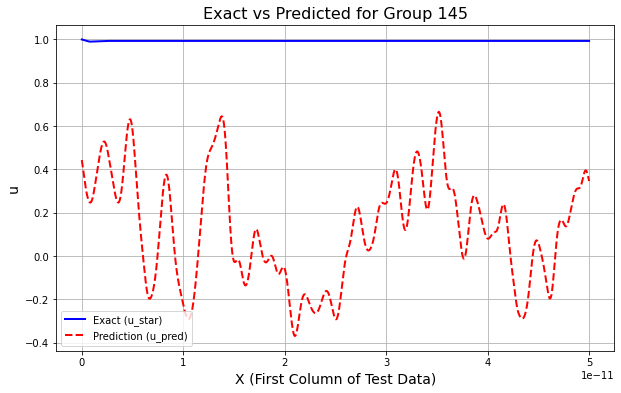

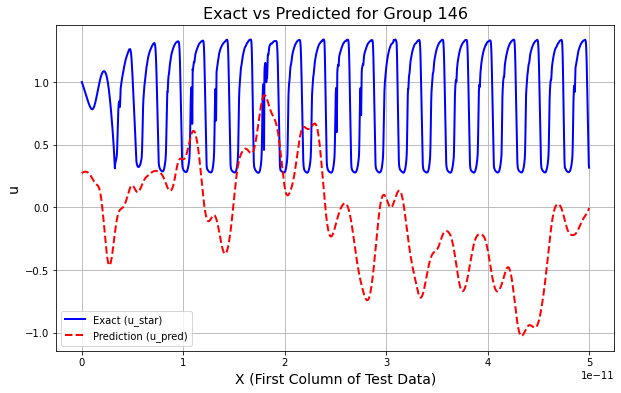

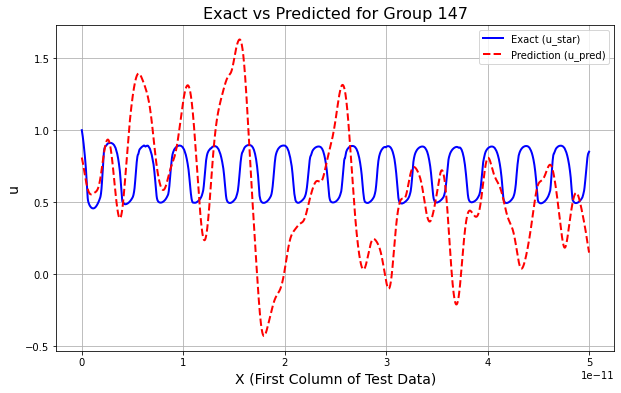

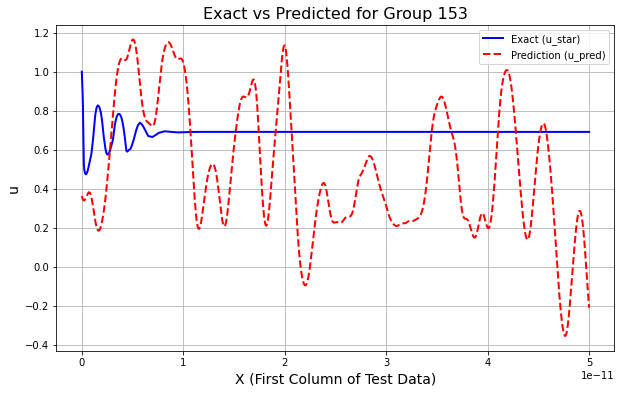

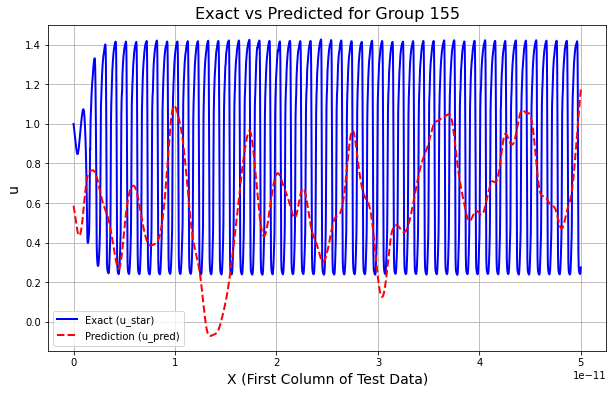

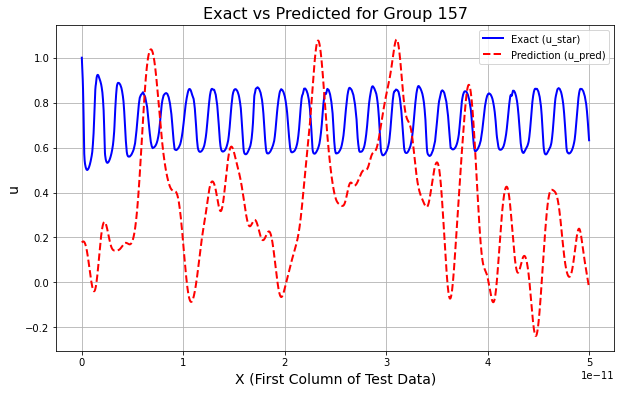

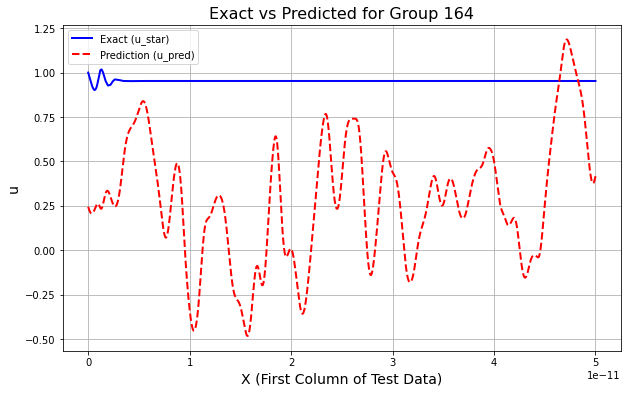

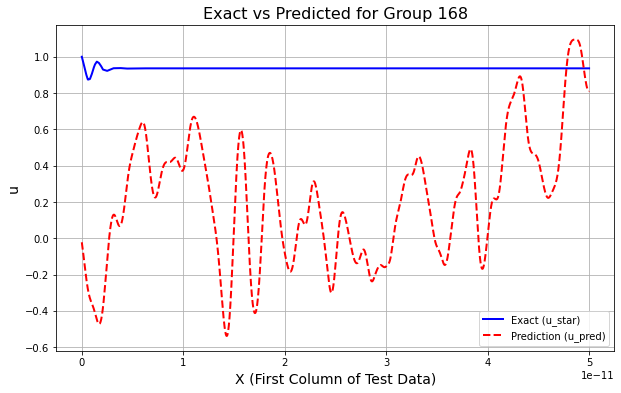

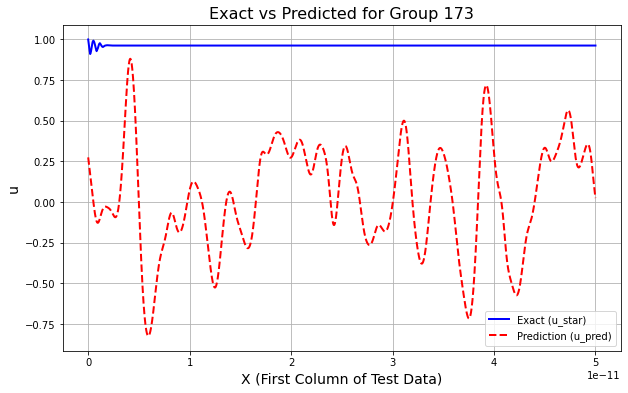

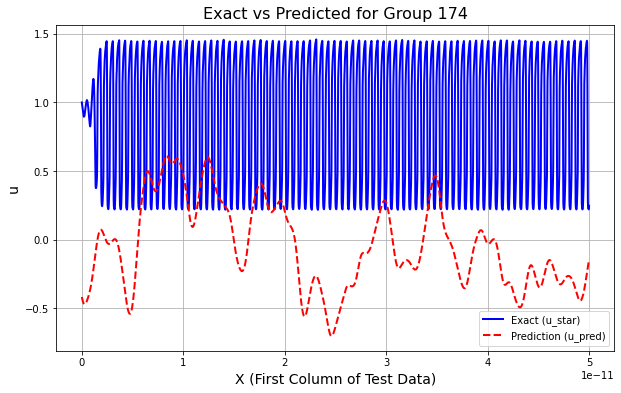

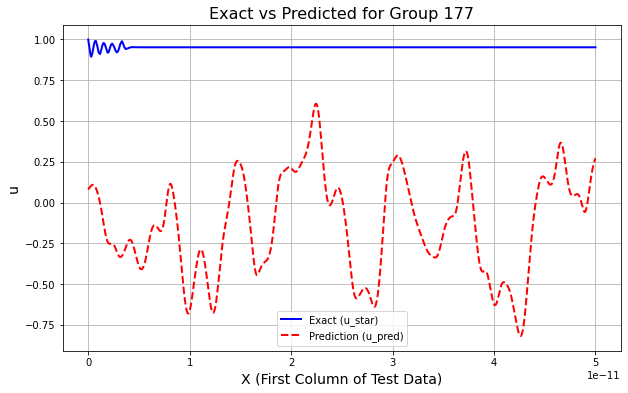

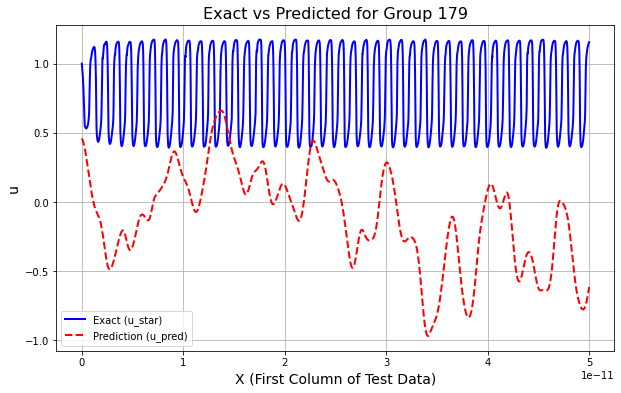

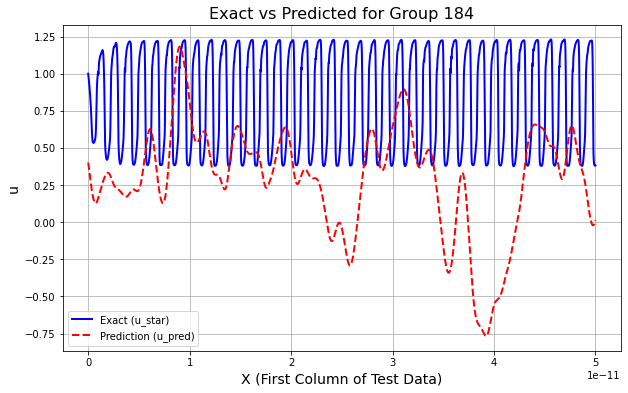

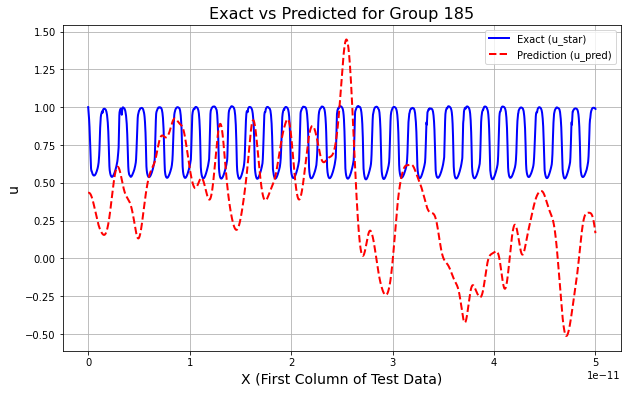

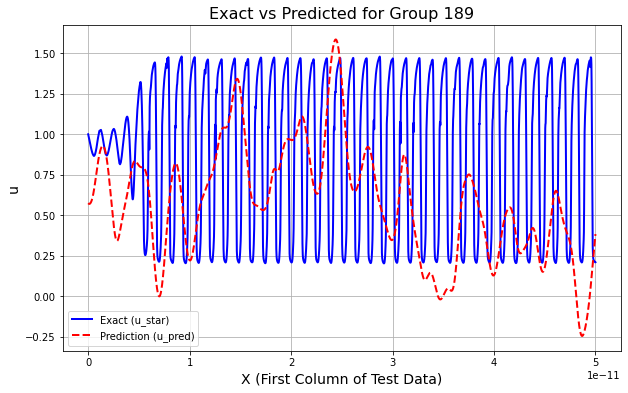

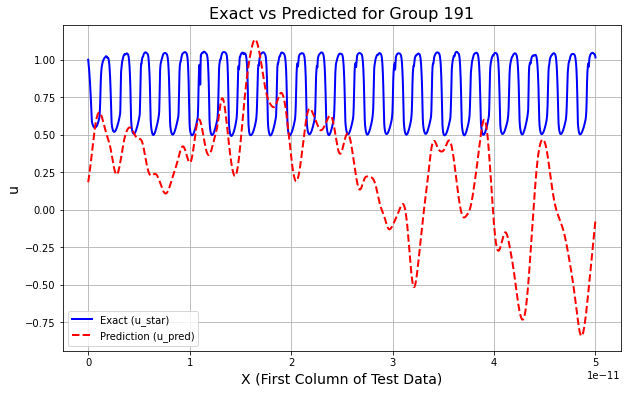

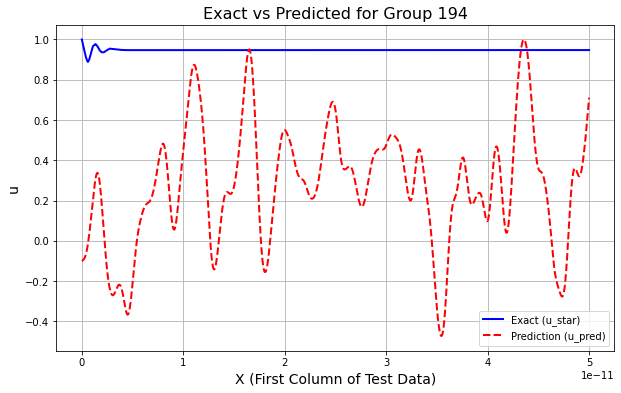

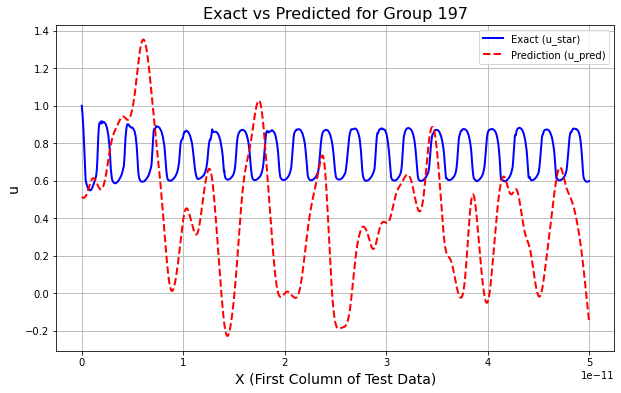

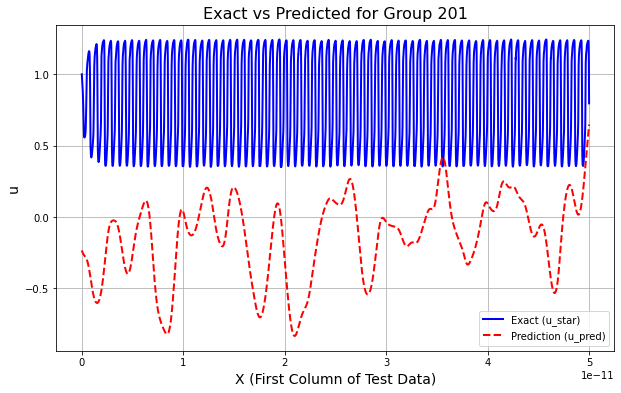

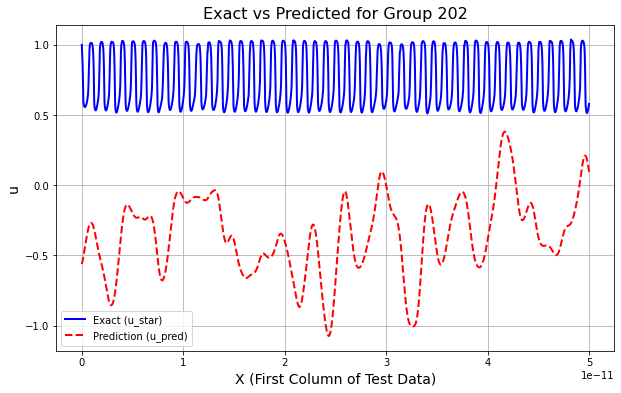

In [392]:
# Get all unique groups from the test data
unique_groups = test_df_with_group['group'].unique()

# Loop through each group and plot
for specific_group in unique_groups:
    # Filter rows belonging to the specific group
    group_df = test_df_with_group[test_df_with_group['group'] == specific_group]

    # Get the corresponding X_star and u_star for the selected group
    X_group = group_df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values  # X_test for the specific group
    u_group = group_df.iloc[:, 1].values[:, None]  # Y_test (u_star) for the specific group

    # Get predicted values corresponding to these indices from u_pred
    group_indices = group_df.index
    u_pred_group = u_pred[np.isin(test_df_with_group.index, group_indices)]  # Use boolean indexing

    # Sort the values for plotting
    sorted_indices = np.argsort(X_group[:, 0])  # Sort based on the first column (X-axis)
    X_group_sorted = X_group[sorted_indices]
    u_group_sorted = u_group[sorted_indices]
    u_pred_group_sorted = u_pred_group[sorted_indices]

    # Plot the results for the current group
    fig = plt.figure(figsize=(10, 6))
    plt.plot(X_group_sorted[:, 0], u_group_sorted, 'b-', label='Exact (u_star)', linewidth=2)  # Exact values
    plt.plot(X_group_sorted[:, 0], u_pred_group_sorted, 'r--', label='Prediction (u_pred)', linewidth=2)  # Predicted values

    plt.xlabel('X (First Column of Test Data)', fontsize=14)
    plt.ylabel('u', fontsize=14)
    plt.title(f'Exact vs Predicted for Group {specific_group}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()


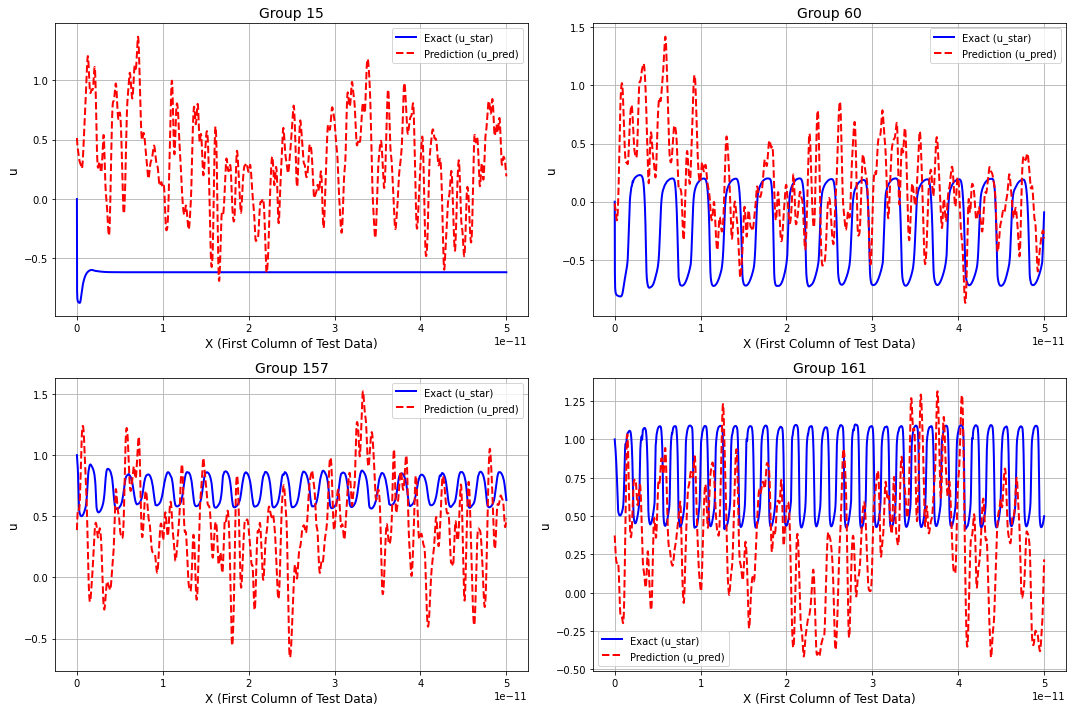

In [107]:
import math

# Get all unique groups from the test data
unique_groups = test_df_with_group['group'].unique()

# Define number of rows and columns for the grid (2 columns)
n_groups = len(unique_groups)
n_cols = 2  # Two columns
n_rows = math.ceil(n_groups / n_cols)  # Calculate the number of rows needed

# Create the figure and axis objects for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each group and plot
for i, specific_group in enumerate(unique_groups):
    # Filter rows belonging to the specific group
    group_df = test_df_with_group[test_df_with_group['group'] == specific_group]

    # Get the corresponding X_star and u_star for the selected group
    X_group = group_df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values  # X_test for the specific group
    u_group = group_df.iloc[:, 1].values[:, None]  # Y_test (u_star) for the specific group

    # Get predicted values corresponding to these indices from u_pred
    group_indices = group_df.index
    u_pred_group = u_pred[np.isin(test_df_with_group.index, group_indices)]  # Use boolean indexing

    # Sort the values for plotting
    sorted_indices = np.argsort(X_group[:, 0])  # Sort based on the first column (X-axis)
    X_group_sorted = X_group[sorted_indices]
    u_group_sorted = u_group[sorted_indices]
    u_pred_group_sorted = u_pred_group[sorted_indices]

    # Plot on the corresponding subplot axis
    ax = axes[i]
    ax.plot(X_group_sorted[:, 0], u_group_sorted, 'b-', label='Exact (u_star)', linewidth=2)
    ax.plot(X_group_sorted[:, 0], u_pred_group_sorted, 'r--', label='Prediction (u_pred)', linewidth=2)

    ax.set_xlabel('X (First Column of Test Data)', fontsize=12)
    ax.set_ylabel('u', fontsize=12)
    ax.set_title(f'Group {specific_group}', fontsize=14)
    ax.legend()
    ax.grid(True)

# Turn off any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [133]:
u_pred_train = model.predict_u(X_u)

In [134]:
u_pred_train.shape

(204561, 1)

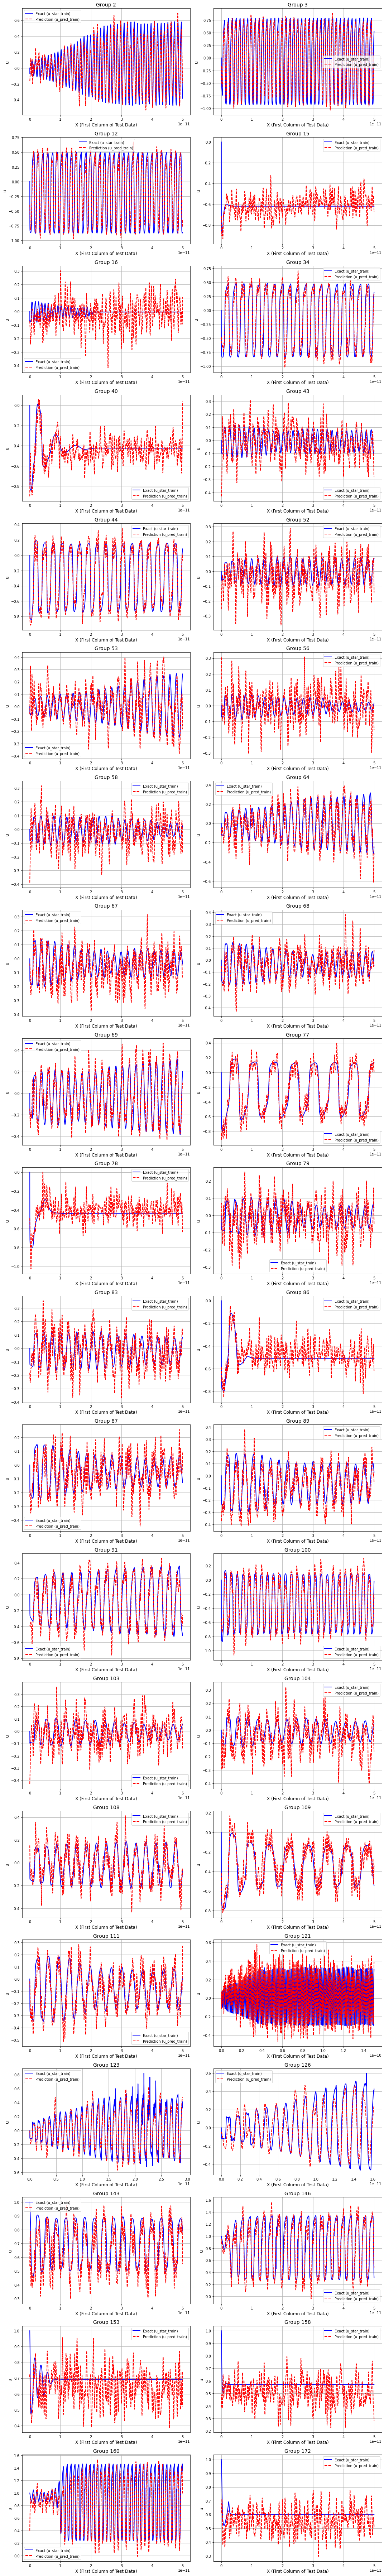

In [135]:
import math

# Get all unique groups from the test data
unique_groups = train_df_with_group['group'].unique()

# Define number of rows and columns for the grid (2 columns)
n_groups = len(unique_groups)
n_cols = 2  # Two columns
n_rows = math.ceil(n_groups / n_cols)  # Calculate the number of rows needed

# Create the figure and axis objects for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each group and plot
for i, specific_group in enumerate(unique_groups):
    # Filter rows belonging to the specific group
    group_df = train_df_with_group[train_df_with_group['group'] == specific_group]

    # Get the corresponding X_star and u_star for the selected group
    X_group = group_df.iloc[:, [0, 2, 3, 4, 5, 6, 7]].values  # X_test for the specific group
    u_group = group_df.iloc[:, 1].values[:, None]  # Y_test (u_star) for the specific group

    # Get predicted values corresponding to these indices from u_pred
    group_indices = group_df.index
    u_pred_train_group = u_pred_train[np.isin(train_df_with_group.index, group_indices)]  # Use boolean indexing

    # Sort the values for plotting
    sorted_indices = np.argsort(X_group[:, 0])  # Sort based on the first column (X-axis)
    X_group_sorted = X_group[sorted_indices]
    u_group_sorted = u_group[sorted_indices]
    u_pred_train_group_sorted = u_pred_train_group[sorted_indices]

    # Plot on the corresponding subplot axis
    ax = axes[i]
    ax.plot(X_group_sorted[:, 0], u_group_sorted, 'b-', label='Exact (u_star_train)', linewidth=2)
    ax.plot(X_group_sorted[:, 0], u_pred_train_group_sorted, 'r--', label='Prediction (u_pred_train)', linewidth=2)

    ax.set_xlabel('X (First Column of Test Data)', fontsize=12)
    ax.set_ylabel('u', fontsize=12)
    ax.set_title(f'Group {specific_group}', fontsize=14)
    ax.legend()
    ax.grid(True)

# Turn off any empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
